# Tutorial: Introduction to Unsupervised Learning with a Focus on PCA

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2F07_tutorial_unsupervised_learning_pca.ipynb)

Tutorial to the class [Introduction to Unsupervised Learning with a Focus on PCA](07_unsupervised_learning_pca.ipynb) based on the same case study as in [Tutorial: Regularization, Model Selection and Evaluation](05_tutorial_regularization_selection_evaluation.ipynb).

<div class="alert alert-block alert-info">
    <b>Tutorial Objectives</b>
    
- Apply Principal Component Analysis (PCA) to climate data to analyze patterns of variability
- (Combine PCA reduction/$k$-means clustering to Ordinary Least Squares (OLS) to predict climate variables)
- (Use cross-validation to regularize the OLS with the number of retained Empirical Orthogonal Functions (EOFs) or clusters).
</div>

## Dataset presentation

- Input:
  - [Geopotential height](https://en.wikipedia.org/wiki/Geopotential_height) at 500hPa
    - Domain: North Atlantic
    - Spatial resolution: $0.5° \times 0.625°$
    - Time resolution: monthly
    - Period: 1980-2021
    - Units: m
    - Source: [MERRA-2 reanalysis](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/)
- Target:
  - Onshore wind capacity factors
    - Domain: Metropolitan France
    - Spatial resolution: regional mean
    - Time resolution: daily
    - Period: 2014-2021
    - Units:
    - Source: [RTE](https://opendata.reseaux-energies.fr/)

In [1]:
# Import modules
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', size=14)

# Data directory
DATA_DIR = Path('data')

# Filename to geopotential height at 500hPa from MERRA-2 reanalysis
START_DATE = '19800101'
END_DATE = '20220101'
filename = 'merra2_analyze_height_500_month_{}-{}.nc'.format(START_DATE, END_DATE)
z500_label = 'Geopotential height (m)'

> ***Question***
> - Read the geopotential height data using `xarray.load_dataset` and print it.

In [2]:
# answer cell
# Import xarray
import xarray as xr

# Read dataset with xarray
filepath = Path(DATA_DIR, filename)
ds = xr.load_dataset(filepath)

# Select geopotential height variable
da = ds['height_500']
da

<xarray.DataArray 'height_500' (time: 504, lat: 45, lon: 72)>
array([[[9136.353  , 9137.497  , 9138.723  , ..., 9154.949  ,
         9152.869  , 9151.17   ],
        [9127.387  , 9128.267  , 9129.56   , ..., 9145.458  ,
         9143.617  , 9142.326  ],
        [9107.899  , 9109.126  , 9110.383  , ..., 9125.637  ,
         9124.2295 , 9123.1455 ],
        ...,
        [ 736.04663,  735.869  ,  735.73663, ...,  733.24615,
          733.5185 ,  733.829  ],
        [ 457.50705,  457.4112 ,  457.31995, ...,  455.6996 ,
          455.82803,  455.9666 ],
        [ 176.20937,  176.19128,  176.17307, ...,  175.86165,
          175.88235,  175.90346]],

       [[9143.846  , 9144.417  , 9145.188  , ..., 9158.303  ,
         9157.298  , 9157.574  ],
        [9135.325  , 9135.736  , 9136.581  , ..., 9148.72   ,
         9147.877  , 9147.993  ],
        [9116.054  , 9116.738  , 9117.455  , ..., 9129.612  ,
         9129.148  , 9128.99   ],
...
        [ 737.015  ,  736.9474 ,  736.89954, ...,  725.486  ,
          725.47253,  725.50726],
        [ 457.0361 ,  457.0116 ,  456.99075, ...,  452.33005,
          452.3201 ,  452.32614],
        [ 175.76747,  175.76505,  175.76236, ...,  175.01283,
          175.01173,  175.01164]],

       [[9152.831  , 9153.601  , 9154.307  , ..., 9177.096  ,
         9176.428  , 9175.797  ],
        [9145.126  , 9145.75   , 9146.236  , ..., 9167.63   ,
         9166.749  , 9165.763  ],
        [9127.585  , 9128.061  , 9128.329  , ..., 9147.203  ,
         9146.124  , 9144.921  ],
        ...,
        [ 734.2283 ,  734.4256 ,  734.63464, ...,  737.38837,
          737.2761 ,  737.18634],
        [ 455.60513,  455.66605,  455.72946, ...,  456.62033,
          456.57556,  456.53754],
        [ 175.44823,  175.45422,  175.46037, ...,  175.61407,
          175.6084 ,  175.60269]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2021-12-01
  * lat      (lat) float64 0.75 2.75 4.75 6.75 8.75 ... 82.75 84.75 86.75 88.75
  * lon      (lon) float64 -99.06 -96.56 -94.06 -91.56 ... 73.44 75.94 78.44

> ***Question (optional)***
> - Coarsen the grid resolution of the geopotential height field to reduce the number of variables.

In [3]:
# answer cell
# Downsample geopotential height
N_GRID_AVG = 2
da = da.coarsen(lat=N_GRID_AVG, boundary='trim').mean().coarsen(                                                                                                 
    lon=N_GRID_AVG, boundary='trim').mean()

> ***Question***
> - Compute the mean and the variance of the geopotential height with the `mean` and `var` methods.
> - Plot the mean with the `plot` method.
> - Do a filled-contour plot of the variance with the `plot.contourf` method.

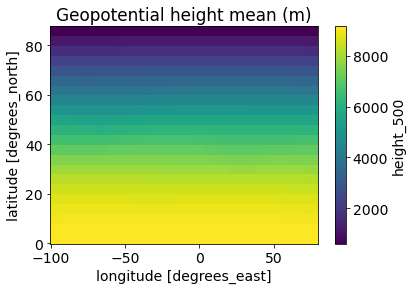

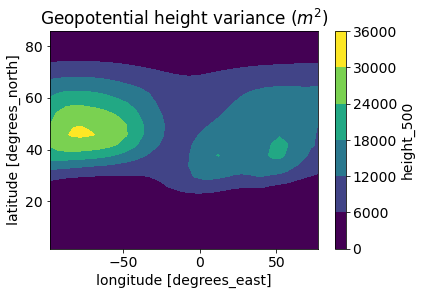

In [4]:
# answer cell
# Compute the mean
da_mean = da.mean('time')

# Plot mean per grid point with pcolormesh
plt.figure()
da_mean.plot()
plt.title(r'Geopotential height mean (m)')

# Compute deviations from the mean
da_dev = da - da_mean

# Compute the variance
da_var = da_dev.var('time')

# Plot variance per grid point with contourf
plt.figure()
da_var.plot.contourf()
_ = plt.title(r'Geopotential height variance ($m^2$)')

> ***Question***
> - Plot the variance of the geopotential height on the map. To do so, import `cartopy.crs` and use it to define the `projection` argument of `plt.subplot`, and use the `coastlines` and the `gridlines` method of the axes.

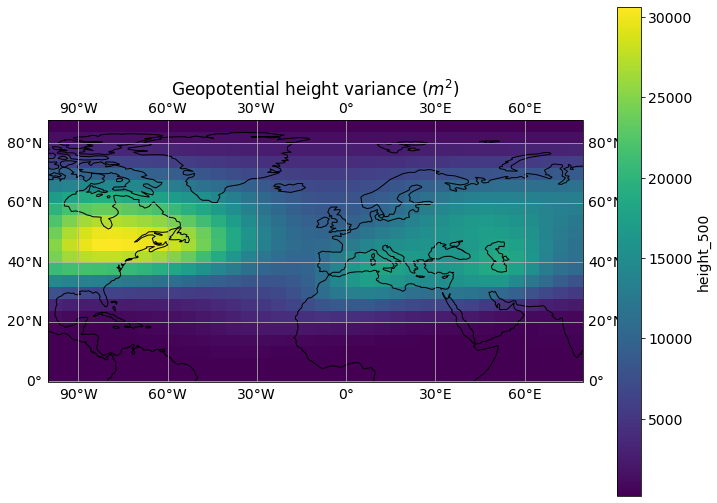

In [5]:
# answer cell
# Import Cartopy's coordinate reference system
import cartopy.crs as ccrs

# Plot variance with costlines and gridlines
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_var.plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Geopotential height variance ($m^2$)')

> ***Question***
> - Scale the geopotential-height deviations to account for variations in the area represented by each grid point.
> - Plot the variance of the scaled geopotential height.
> - Qualitatively describe the mean and variance of the geopotential height.

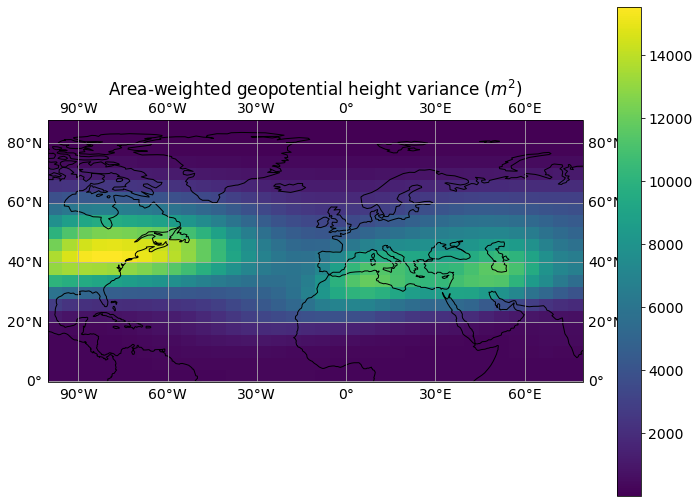

In [6]:
# answer cell
# Get grid-point area coefficients
coef = np.cos(np.deg2rad(da['lat']))

# Scale height by coefficient
da_scaled = da_dev * coef

# Plot scaled variance with costlines and gridlines
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_scaled.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Area-weighted geopotential height variance ($m^2$)')

Answer:

> ***Question***
> - Estimate the covariance matrix of the scaled geopotential height using the `stack` method of data arrays.

In [7]:
# answer cell
# Get input matrix
da_scaled_2d = da_scaled.stack(latlon=['lat', 'lon'])
X = da_scaled_2d.values

# Estimate covariance matrix
Sigma = np.cov(X.T)

> ***Question***
> - Compute EOFs and corresponding variances using `np.linalg.eigh`.

In [8]:
# answer cell
# Compute eigenvalues and eigenvectors
lam, V = np.linalg.eigh(Sigma)

> ***Question***
> - Sort the EOFs and corresponding variances by decreasing variances.
> - Plot the fraction of variance "explained" by the leading 20 EOFs.
> - Interpret your results.

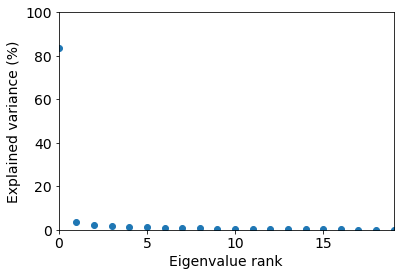

In [9]:
# answer cell
# Sort eigenvalues and eigenvectors by decreasing eigenvalues
isort = np.argsort(-lam)
lam = lam[isort]
V = V[:, isort]

# Convert eigenvalues to explained variance percentage
expvar = lam / lam.sum() * 100

# Plot first 20 explained variances
n_eig = 20
xlim = [0., n_eig - 1]
x = np.arange(len(expvar[:n_eig]))
plt.figure()
plt.scatter(np.arange(len(expvar[:n_eig])), expvar[:n_eig])
plt.xlim(xlim)
plt.ylim(0., 100.)
plt.xticks(range(0, n_eig, 5))
plt.xlabel('Eigenvalue rank')
_ = plt.ylabel('Explained variance (%)')

Answer: 

> ***Question***
> - Plot the leading EOF on a map.
> - To what physical phenomenon could this pattern be associated to?

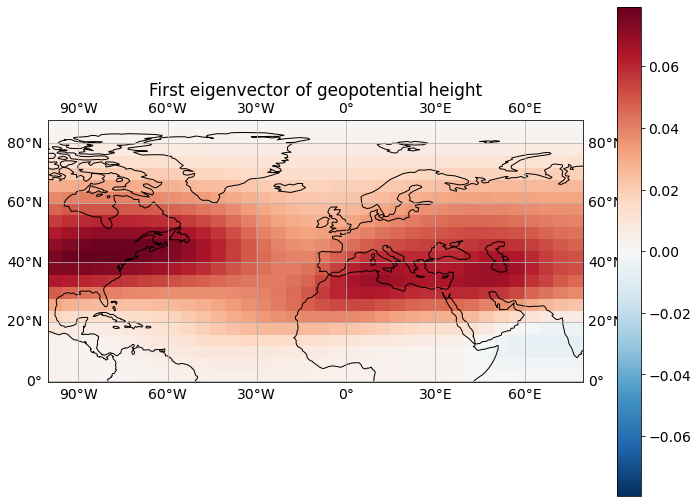

In [10]:
# answer cell
# Convert first eigenvector to data array
da_scaled_2d_v0 = xr.DataArray(V[:, 0], coords=[
    da_scaled_2d.coords['latlon']])

# Unstack latitudes and longitudes
da_v0 = da_scaled_2d_v0.unstack('latlon')

# Plot first eigenvector
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_v0.plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title('First eigenvector of geopotential height')

Answer: 

> ***Question***
> - Compute the principal component associated with the leading EOF.
> - Compare its variance to the corresponding eigenvalue and explain your result.
> - Plot this principal component.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

Variance of first principal component: 	2.31e+06 (m^2)
Corresponding eigenvalue: 		2.31e+06 (m^2)


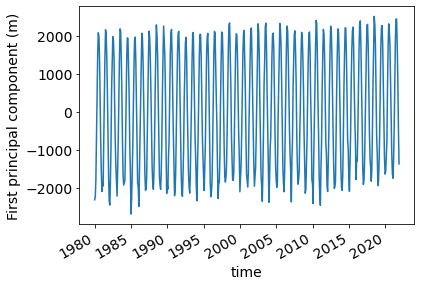

In [11]:
# answer cell
# Compute first principal component
a0 = X @ V[:, 0]

# Compare variance of first principal component to corresponding eigenvalue
print('Variance of first principal component: \t{:.2e} (m^2)'.format(a0.var()))
print('Corresponding eigenvalue: \t\t{:.2e} (m^2)'.format(lam[0]))

# Plot first principal component
da_a0 = xr.DataArray(a0, coords=[da_scaled_2d.coords['time']])

da_a0.plot()
_ = plt.ylabel('First principal component (m)')

Answer: 

> ***Question (optional)***
> - Use the `scipy.signal.welch` to estimate the Power Spectral Density (PSD) of the leading principal component and plot it.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

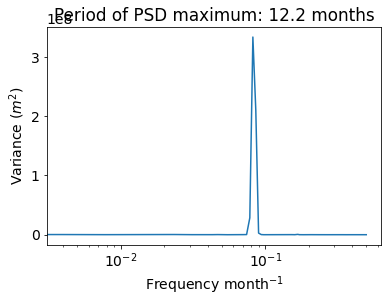

In [12]:
# answer cell
# Import signal module from Scipy
from scipy import signal

# Get PSD from Welch estimator
freqs, psd = signal.welch(a0)

# Plot and give period at maximum in title
plt.semilogx(freqs, psd)
plt.xlabel(r'Frequency month$^{-1}$')
plt.ylabel(r'Variance $(m^2)$')
_ = plt.title('Period of PSD maximum: {:.1f} months'.format(1. / freqs[psd.argmax()]))

> ***Question***
> - Compute the seasonal cycle of the geopotential height (averages over all years of the same month of the year for each month) with the `groupby` of data arrays.
> - Plot all 12 months. You can use the `col` option of the `plot` method of data arrays.
> - Also plot the variance of the seasonal cycle on a map.
> - Confirm or reconsider you previous answer on the physical phenomenon that could be associated to the leading EOF.

<Figure size 432x288 with 0 Axes>

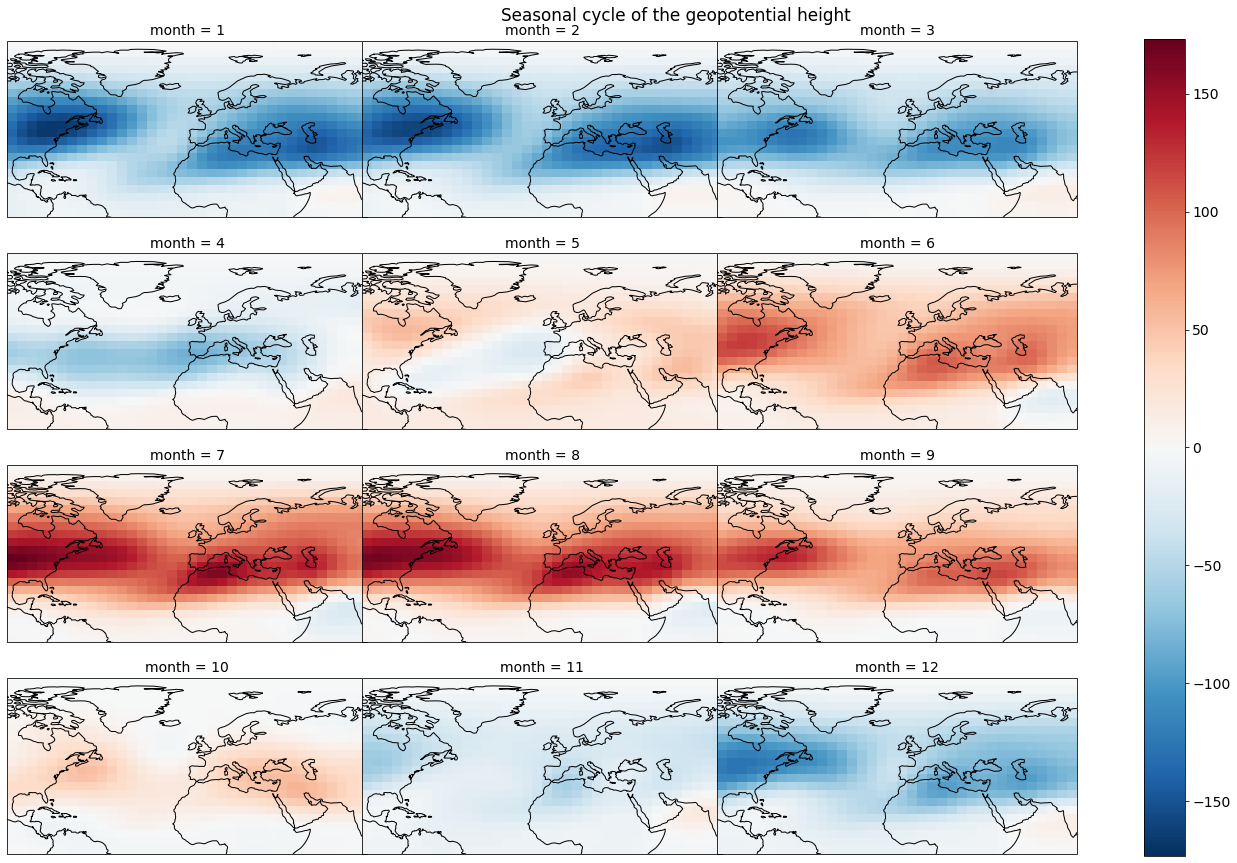

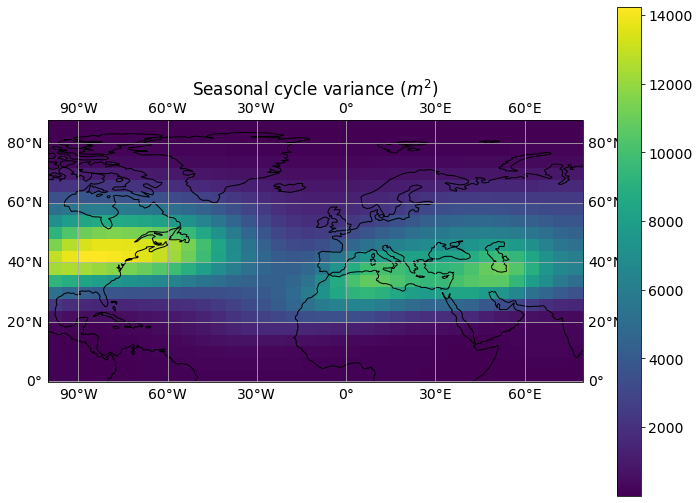

In [13]:
# answer cell
# Compute monthly seasonal cycle
gps = da_scaled.groupby('time.month')

# Get seasonal cycle
da_seasonal = gps.mean()

# Plot each month of seasonal cycle
fig = plt.figure()
col_wrap = 3
g = da_seasonal.plot(x='lon', y='lat', col='month', col_wrap=col_wrap,
                     subplot_kws=dict(projection=ccrs.PlateCarree()),
                     aspect=2)
for ax in g.axes.flat:
    ax.coastlines()
_ = plt.suptitle('Seasonal cycle of the geopotential height', y=1)

# Plot variance of seasonal cycle
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_seasonal.var('month').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Seasonal cycle variance $(m^2)$')

Answer: 

> ***Question***
> - Compute seasonal anomalies (deviations from the seasonal cycle) of the geopotential height with `groupby`.
> - Plot the variance of the seasonal anomalies on a map.
> - How does it compare to the variance of the data with the seasonal cycle?

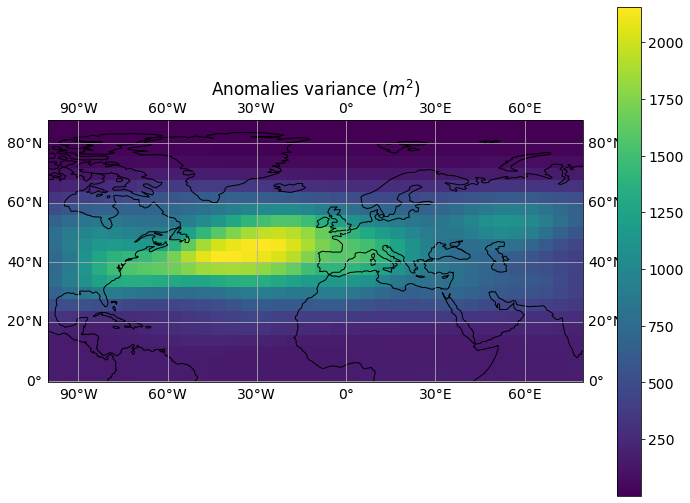

In [14]:
# answer cell
# Get seasonal anomalies
da_anom = da_scaled.groupby('time.month') - da_seasonal

# Plot variance of the seasonal anomalies on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_anom.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Anomalies variance ($m^2$)')

Answer:

> ***Question***
> - Estimate the covariance matrix of the seasonal anomalies.
> - Compute the EOFs and corresponding variances.
> - Plot the explained variances associated with the EOFs together with the cumulative sum of the explained variances.
> - What is the minimum number of EOFs that one needs to keep to explain at least 90% of the variance.

In [15]:
# answer cell
# Get input matrix for seasonal anomalies
da_anom_2d = da_anom.stack(latlon=['lat', 'lon'])
X_anom = da_anom_2d.values

# Estimate covariance matrix
Sigma_anom = np.cov(X_anom.T)

In [16]:
# answer cell
# Compute eigenvalues and eigenvectors
lam_anom, V_anom = np.linalg.eigh(Sigma_anom)

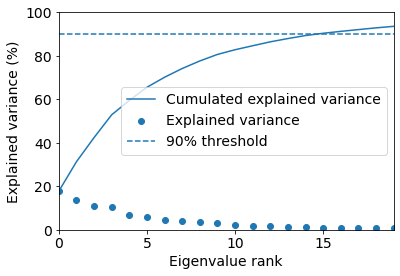

In [17]:
# answer cell
# Sort eigenvalues and eigenvectors by decreasing eigenvalues
isort = np.argsort(-lam_anom)
lam_anom = lam_anom[isort]
V_anom = V_anom[:, isort]

# Convert eigenvalues to explained variance percentage
expvar_anom = lam_anom / lam_anom.sum() * 100
cumexpvar_anom = expvar_anom.cumsum()

# Plot first 20 explained variances
n_eig = 20
xlim = [0., n_eig - 1]
x = np.arange(len(expvar_anom[:n_eig]))
plt.figure()
plt.scatter(x, expvar_anom[:n_eig], label='Explained variance')
plt.plot(x, cumexpvar_anom[:n_eig], label='Cumulated explained variance')
plt.hlines(90., *xlim, linestyle='--', label='90% threshold')
plt.xlim(xlim)
plt.ylim(0., 100.)
plt.xticks(range(0, n_eig, 5))
plt.xlabel('Eigenvalue rank')
plt.ylabel('Explained variance (%)')
_ = plt.legend()

Answer:

> ***Question***
> - Plot the leading 4 EOFs and principal components.
> - Can you associate these patterns to known climate phenomena?

<Figure size 432x288 with 0 Axes>

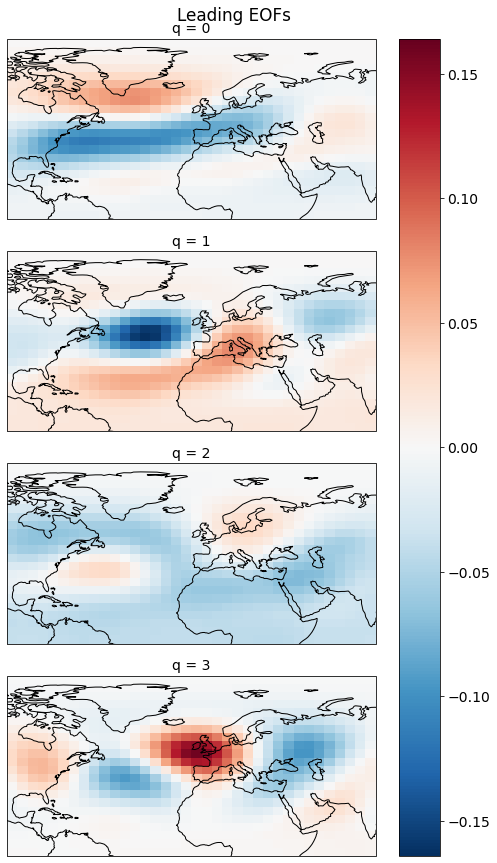

<Figure size 432x288 with 0 Axes>

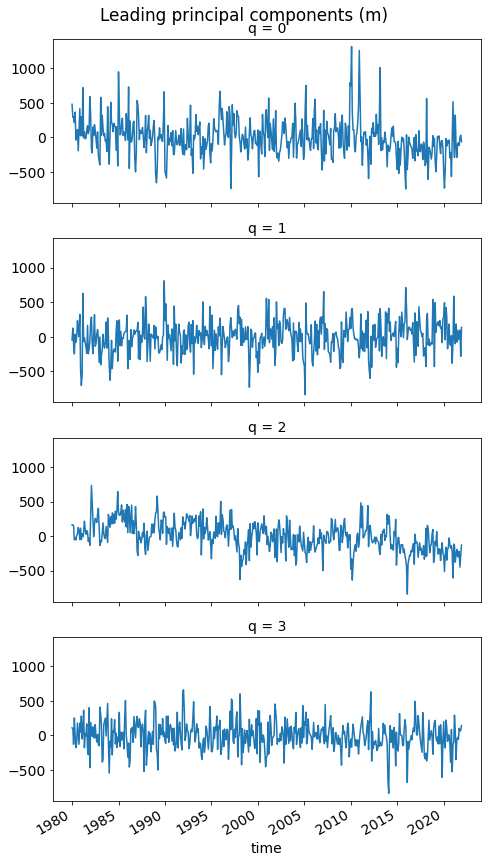

In [18]:
# answer cell
# Plot leading EOFs and principal components
n_eof = 4
coord_eof = 'q', range(n_eof)
da_v_anom = xr.DataArray(V_anom[:, :n_eof], coords=[
    da_anom_2d.coords['latlon'], coord_eof]).unstack('latlon')

plt.figure()
g = da_v_anom.plot(x='lon', y='lat', col='q', col_wrap=1, aspect=2,
                   subplot_kws=dict(projection=ccrs.PlateCarree()))
for ax in g.axes.flat:
    ax.coastlines()
plt.suptitle('Leading EOFs', y=1)    
    
# Compute the leading principal components
A_anom = X_anom @ V_anom[:, :n_eof]

# Plot the leading principal component
plt.figure()
da_a_anom = xr.DataArray(A_anom, coords=[
    da_scaled_2d.coords['time'], coord_eof])
da_a_anom.plot.line(x='time', col='q', col_wrap=1, aspect=2)
_ = plt.suptitle('Leading principal components (m)', y=1)

Answer: 

> ***Question***
> - Reconstruct the inputs from the leading 4 EOFs only.
> - Compare the original time series at a few arbitrary locations to the corresponding reconstructed time series.
> - Plot the variance of the reconstruction on a map.
> - Same question but keeping more EOFs
> - Interpret your results in terms of filtering.

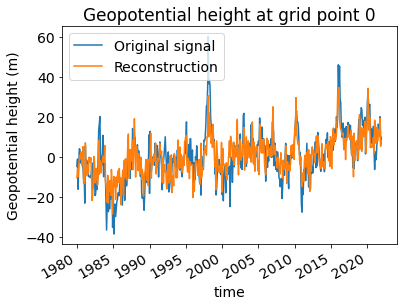

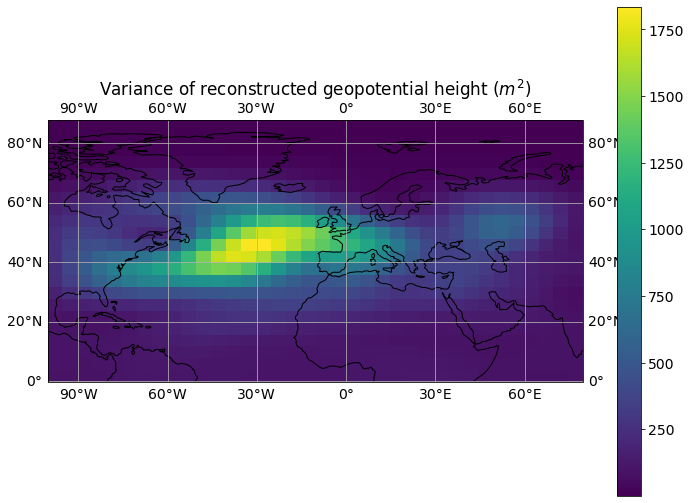

In [19]:
# answer cell
# Reconstruct the data from first 4 principal components
X_rec = A_anom @ V_anom[:, :n_eof].T

# Compare original time series and reconstruction at arbitrary grid points
ilatlon = 0
ts_anom = xr.DataArray(X_anom[:, ilatlon], coords=[da.coords['time']])
ts_rec = xr.DataArray(X_rec[:, ilatlon], coords=[da.coords['time']])
fig, ax = plt.subplots()
ts_anom.plot(ax=ax, label='Original signal')
ts_rec.plot(ax=ax, label='Reconstruction')
ax.set_ylabel(z500_label)
ax.set_title('Geopotential height at grid point {:d}'.format(ilatlon))
plt.legend()

# Convert reconstruction to data array
da_rec_2d = xr.DataArray(X_rec, coords=[
    da.coords['time'], da_scaled_2d.coords['latlon']])

# Unstack latitudes and longitudes
da_rec = da_rec_2d.unstack('latlon')

# Plot variance of reconstruction on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = da_rec.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Variance of reconstructed geopotential height ($m^2$)')

Answer: 

> ***Question (optional)***
> - Design a linear model that best predicts present (not future) wind capacity factors in `data/reseaux_energies_capacityfactor_wind-onshore.csv` using geopotential-height principal components as inputs. To do, use cross-validation to regularize based on the number of leading principal components retained.

In [20]:
# answer cell

> ***Question (optional)***
> - Use $k$-means clustering with `sklearn.cluster.KMeans` to detect "atmospheric regimes" from the geopotential-height data and compare the result to the EOFs obtained above.
> - Design a linear model as above but based on clusters rather than EOFs.

In [21]:
# answer cell

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>